In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import seaborn as sns
import shutil
from keras.callbacks import ModelCheckpoint
from keras.layers import MaxPooling2D, Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from pathlib import Path
from PIL.ExifTags import TAGS, GPSTAGS
from PIL import Image
from skimage.feature import hog
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
import keras.backend as keras

In [9]:
old_base_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks')
old_val_dir = os.path.join(old_base_dir, 'validate')
old_test_dir = os.path.join(old_base_dir, 'test')
old_train_dir = os.path.join(old_base_dir, 'train')

In [10]:
def count_data(base_dir, directories):
    # list to store img counts, and dict to store image paths
    file_counts = []
    img_paths = {}

    for directory in directories:

        img_files = [x for x in os.listdir(os.path.join(base_dir, directory))
            if x.endswith('.jpeg')]

        # find paths to all imgs
        path_names = [os.path.join(base_dir, directory, x) for x in img_files]

        # count img no. and append to file counts
        num_files = len(img_files)
        file_counts.append(num_files)

        # update dict of paths with the given imgs for the sub-dir
        key_name = directory.replace('/', '_').lower()
        img_paths[key_name] = path_names

    return file_counts, img_paths

test/PNEUMONIA : 0
test/NORMAL : 0
train/PNEUMONIA : 0
train/NORMAL : 0
validate/PNEUMONIA : 0
validate/NORMAL : 0


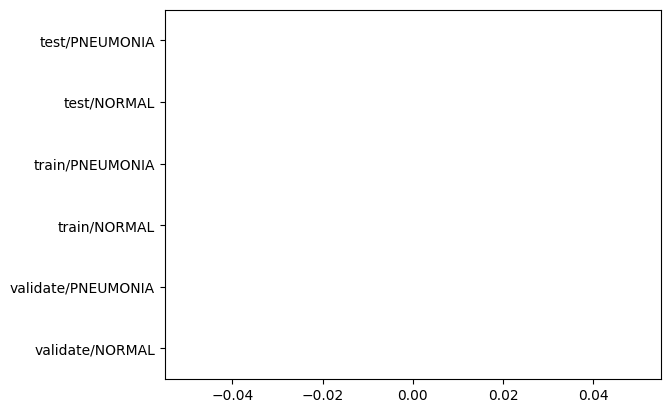

In [11]:
split_type = ['test', 'train', 'validate']
class_type = ['PNEUMONIA', 'NORMAL']
directories = [f"{x}/{y}" for x in split_type for y in class_type]

counts, img_paths = count_data(base_dir, directories)

for subdir, count in zip(directories, counts):
    print(f"{subdir} : {count}")

sns.barplot(y=directories, x=counts)
plt.show()

In [12]:
base_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/work')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validate')
test_dir = os.path.join(base_dir, 'test')

In [13]:
for directory in directories:

    # create new directory structure in kaggle working dir
    new_dir = os.path.join(base_dir, directory)
    Path(new_dir).mkdir(parents=True, exist_ok=True)

    # gather img files in kaggle read-only dir
    img_files = [x for x in os.listdir(os.path.join(old_base_dir, directory))
                 if x.endswith('.jpeg')]

    # find paths to old and new paths for images in current directory
    old_path_names = [os.path.join(old_base_dir, directory, x) for x in img_files]
    new_path_names = [os.path.join(new_dir, x) for x in img_files]

    print(f"Moving and resizing directory: {directory}\n")

    for i in range(len(old_path_names)):

        # load img, resize, and save to new location
        img = Image.open(old_path_names[i])
        img_new = img.resize((360,320), Image.ANTIALIAS)
        img_new.save(new_path_names[i], 'JPEG', quality=90)

Moving and resizing directory: test/PNEUMONIA



<ipython-input-13-78cef8ac2c23>:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_new = img.resize((360,320), Image.ANTIALIAS)


Moving and resizing directory: test/NORMAL

Moving and resizing directory: train/PNEUMONIA

Moving and resizing directory: train/NORMAL

Moving and resizing directory: validate/PNEUMONIA

Moving and resizing directory: validate/NORMAL



In [14]:
def move_img_data(source_dir, destination_dir, proportion=0.2, suffix='.jpeg'):
    """ Move a random proportion of img data from a source to destination directory """

    img_files = [x for x in os.listdir(source_dir) if x.endswith(suffix)]

    move_num = int(np.ceil(len(img_files)*proportion))

    # select random proportion of images to move
    random_indices = np.random.permutation(len(img_files))[:move_num]

    print(f"Moving a total of {move_num} images from "
          f"{source_dir} to {destination_dir}\n")

    # move selected images to destination loc
    for index in random_indices:
        src_path = os.path.join(source_dir, img_files[index])
        dest_path = os.path.join(destination_dir, img_files[index])
        shutil.copyfile(src_path, dest_path)

In [16]:
move_img_data(os.path.join(train_dir, 'NORMAL'),
              os.path.join(val_dir, 'NORMAL'),
              proportion=0.2)
move_img_data(os.path.join(train_dir, 'PNEUMONIA'),
              os.path.join(val_dir, 'PNEUMONIA'),
              proportion=0.2)

Moving a total of 270 images from /content/drive/MyDrive/Colab Notebooks/work/train/NORMAL to /content/drive/MyDrive/Colab Notebooks/work/validate/NORMAL

Moving a total of 777 images from /content/drive/MyDrive/Colab Notebooks/work/train/PNEUMONIA to /content/drive/MyDrive/Colab Notebooks/work/validate/PNEUMONIA



test/PNEUMONIA : 390
test/NORMAL : 234
train/PNEUMONIA : 3883
train/NORMAL : 1349
validate/PNEUMONIA : 782
validate/NORMAL : 276


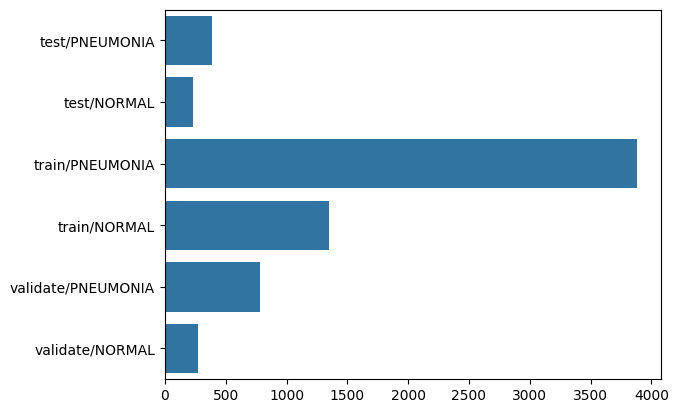

In [17]:
counts, img_paths = count_data(base_dir, directories)

for subdir, count in zip(directories, counts):
    print(f"{subdir} : {count}")

sns.barplot(y=directories, x=counts)
plt.show()

In [18]:
def create_dataframe(data_dir):
    """ Returns a dataframe consisting of img path and label, where
        0 is normal and 1 is pneumonia """
    data = []
    labels = []

    # obtain image paths for all training data
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneunomia_dir = os.path.join(data_dir, 'PNEUMONIA')
    normal_data = [x for x in os.listdir(normal_dir) if x.endswith('.jpeg')]
    pneunomia_data = [x for x in os.listdir(pneunomia_dir) if x.endswith('.jpeg')]

    # append img path and labels for each
    for normal in normal_data:
        data.append(os.path.join(normal_dir, normal))
        labels.append(0)
    for pneumonia in pneunomia_data:
        data.append(os.path.join(pneunomia_dir, pneunomia_dir))
        labels.append(1)

    # return pandas dataframe
    return pd.DataFrame({'Image_path' : data, 'Label' : labels})

In [19]:
train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)
test_df = create_dataframe(test_dir)

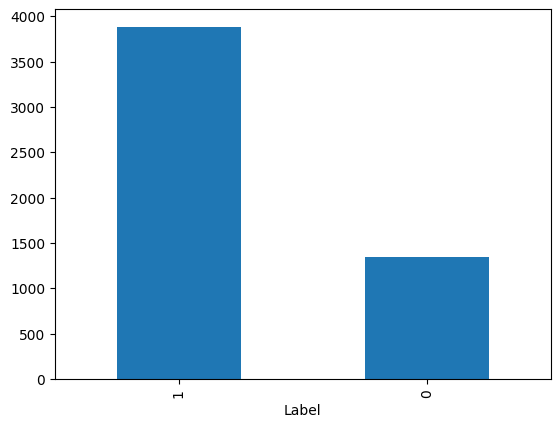

In [20]:
train_df['Label'].value_counts().plot.bar()
plt.show()

In [21]:
def duplicate_data(file_dir, suffix='.jpeg'):
    """ duplicate img data within destination directory """

    img_files = [x for x in os.listdir(file_dir) if x.endswith(suffix)]

    for img in img_files:
        src_path = os.path.join(file_dir, img)
        dup_img = f"{img[:-len(suffix)]}_2{suffix}"
        dest_path = os.path.join(file_dir, dup_img)
        shutil.copyfile(src_path, dest_path)

In [22]:
duplicate_data(os.path.join(train_dir, 'NORMAL'))

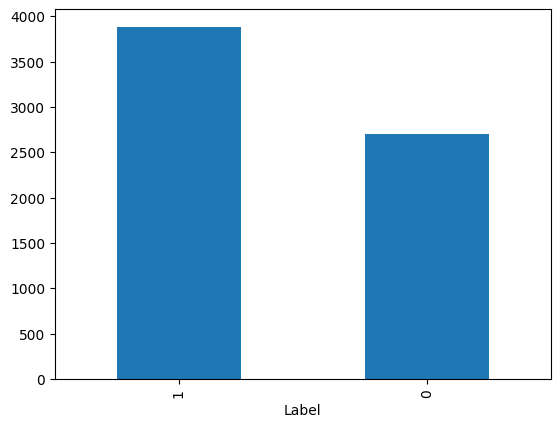

In [23]:
train_df = create_dataframe(train_dir)
train_df['Label'].value_counts().plot.bar()
plt.show()

In [25]:
img_height, img_width = 150, 150
batch_size = 10

# training data augmentation - rotate, shear, zoom and flip
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1.0 / 255.0,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip=True)

# no augmentation for test data - only rescale
test_datagen = ImageDataGenerator(rescale = 1. / 255.0)

# generate batches of augmented data from training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# generate val data from val dir
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

nb_train_samples = len(train_generator.classes)
nb_validation_samples = len(validation_generator.classes)

Found 6581 images belonging to 2 classes.
Found 1058 images belonging to 2 classes.


In [26]:
def create_CNN(input_size=(150, 150)):
    """ Basic CNN with 4 Conv layers, each followed by a max pooling """
    cnn_model = Sequential()

    # four Conv layers with max pooling
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    cnn_model.add(MaxPooling2D(2, 2))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(2, 2))
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(2, 2))
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D(2, 2))

    # flatten output and feed to dense layer, via dropout layer
    cnn_model.add(Flatten())
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(512, activation='relu'))

    # add output layer - sigmoid since we only have 2 outputs
    cnn_model.add(Dense(1, activation='sigmoid'))

    cnn_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return cnn_model

In [27]:
CNN_model = create_CNN()
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [28]:
save_path ="basic_cnn_best_weights.hdf5"

trg_checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy',
                                 verbose=1, save_best_only=True, mode='max')

trg_callbacks = [trg_checkpoint]

In [29]:
steps_per_epoch = np.ceil(nb_train_samples/batch_size)

# validation batch steps (val_size / batch_size):
val_steps_per_epoch = np.ceil(nb_validation_samples/batch_size)

In [30]:
history = CNN_model.fit(train_generator, epochs=50,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=validation_generator,
                        validation_steps=val_steps_per_epoch,
                        callbacks=trg_callbacks,
                        shuffle=True)

Epoch 1/50
659/659 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.7403
Epoch 1: val_accuracy improved from -inf to 0.92344, saving model to basic_cnn_best_weights.hdf5
659/659 [==============================] - 81s 113ms/step - loss: 0.5119 - accuracy: 0.7403 - val_loss: 0.2010 - val_accuracy: 0.9234


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
659/659 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8632
Epoch 2: val_accuracy did not improve from 0.92344
659/659 [==============================] - 74s 112ms/step - loss: 0.3282 - accuracy: 0.8632 - val_loss: 0.2158 - val_accuracy: 0.9074
Epoch 3/50
659/659 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.8910
Epoch 3: val_accuracy improved from 0.92344 to 0.92722, saving model to basic_cnn_best_weights.hdf5
659/659 [==============================] - 75s 114ms/step - loss: 0.2852 - accuracy: 0.8910 - val_loss: 0.1852 - val_accuracy: 0.9272
Epoch 4/50
659/659 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8935
Epoch 4: val_accuracy did not improve from 0.92722
659/659 [==============================] - 74s 112ms/step - loss: 0.2796 - accuracy: 0.8935 - val_loss: 0.2389 - val_accuracy: 0.9130
Epoch 5/50
659/659 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.8993
Epoch 5: val

In [32]:
CNN_model.save('basic_cnn_model_1.hdf5')

# save the history of training to a datafile for later retrieval
with open('history_basic_cnn_model_1.pickle',
          'wb') as pickle_file:
    pickle.dump(history.history, pickle_file)

loaded_model = False

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
CNN_model = load_model('basic_cnn_best_weights.hdf5')

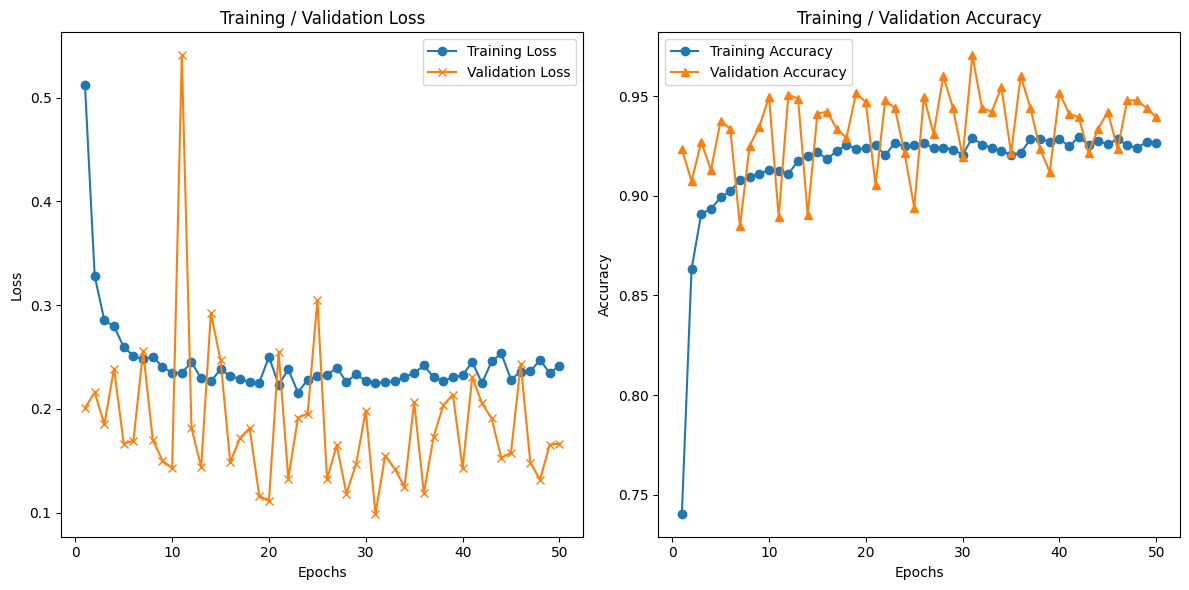

In [34]:
if loaded_model:
    trg_hist = history
else:
    trg_hist = history.history

trg_loss = trg_hist['loss']
val_loss = trg_hist['val_loss']

trg_acc = trg_hist['accuracy']
val_acc = trg_hist['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [35]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width),
                                                  batch_size=4, class_mode='binary')

test_loss, test_accuracy = CNN_model.evaluate_generator(test_generator)
print(f"Test accuracy: {test_accuracy}")

Found 624 images belonging to 2 classes.


<ipython-input-35-6c5e8ea20863>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = CNN_model.evaluate_generator(test_generator)


Test accuracy: 0.9022436141967773


In [36]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 624 images belonging to 2 classes.


In [37]:
y_labels = np.expand_dims(test_generator.classes, axis=1)
nb_test_samples = len(y_labels)

y_preds = CNN_model.predict(test_generator,
                            steps=np.ceil(nb_test_samples/batch_size))

# round predictions to 0 (Normal) or 1 (Pneumonia)
y_preds = np.rint(y_preds)

63/63 [==============================] - 3s 48ms/step


In [38]:
incorrect = (y_labels[:, 0] != y_preds[:, 0]).sum()

# print the basic results of the model
print(f"Accuracy: {accuracy_score(y_labels[:, 0], y_preds[:, 0])*100:.2f}%")
print(f"F1 Score: {f1_score(y_labels[:, 0], y_preds[:, 0]):.2f}")
print(f"Samples incorrectly classified: {incorrect} out of {len(y_labels)}")

Accuracy: 90.22%
F1 Score: 0.93
Samples incorrectly classified: 61 out of 624


In [39]:
print(classification_report(y_labels[:, 0], y_preds[:, 0]))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       234
           1       0.87      1.00      0.93       390

    accuracy                           0.90       624
   macro avg       0.93      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



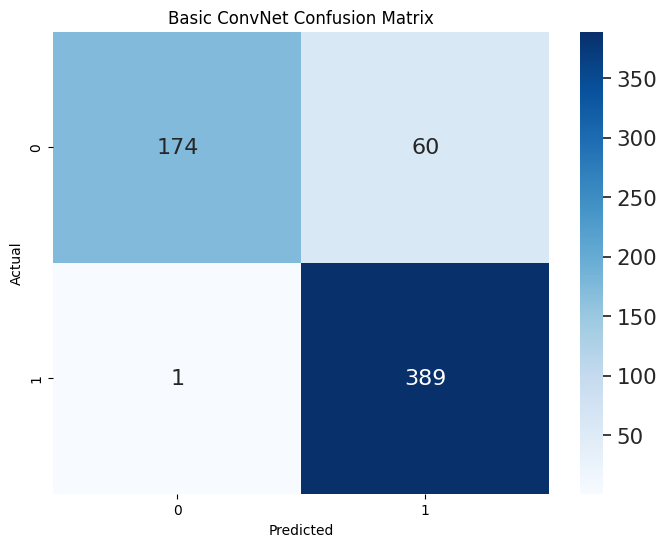

In [40]:
def plot_confusion_matrix(true_y, pred_y, title='Confusion Matrix', figsize=(8,6)):
    """ Custom function for plotting a confusion matrix for predicted results """
    conf_matrix = confusion_matrix(true_y, pred_y)
    conf_df = pd.DataFrame(conf_matrix, columns=np.unique(true_y), index = np.unique(true_y))
    conf_df.index.name = 'Actual'
    conf_df.columns.name = 'Predicted'
    plt.figure(figsize = figsize)
    plt.title(title)
    sns.set(font_scale=1.4)
    sns.heatmap(conf_df, cmap="Blues", annot=True,
                annot_kws={"size": 16}, fmt='g')
    plt.show()
    return


# plot a confusion matrix of our results
plot_confusion_matrix(y_labels[:, 0], y_preds[:, 0], title="Basic ConvNet Confusion Matrix")